**Preprocessing**

Importing Libraries

In [34]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import traceback
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

 Loading Data

In [35]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv("/content/diabetes (1).csv", names=columns, header=0)

Replacing biologically implausible zeroes with NaN

In [36]:
na_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[na_columns] = df[na_columns].replace(0, np.nan)

Separating Features and Labels

In [37]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

KNN Imputation

In [38]:
# Apply KNN imputation (after standardizing for distance-based algorithm)
scaler_before_impute = StandardScaler()
X_scaled_for_knn = scaler_before_impute.fit_transform(X)

# KNN Imputer (n_neighbors=5 is common)
imputer = KNNImputer(n_neighbors=5)
X_imputed_scaled = imputer.fit_transform(X_scaled_for_knn)

Dataframe Convertion and Clipping Values

In [39]:
# Convert back to DataFrame with original column names
X_imputed = pd.DataFrame(scaler_before_impute.inverse_transform(X_imputed_scaled), columns=X.columns)

# Clipping values after imputation
X_imputed['BloodPressure'] = X_imputed['BloodPressure'].clip(lower=40, upper=140)
X_imputed['BMI'] = X_imputed['BMI'].clip(lower=15, upper=50)
X_imputed['Glucose'] = X_imputed['Glucose'].clip(lower=50, upper=200)

Splitting Train and Test data followed by Scaling

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Final scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Saving Processed Data

In [42]:
os.makedirs('data', exist_ok=True)
with open('data/X_train.pkl', 'wb') as f: pickle.dump(X_train_scaled, f)
with open('data/X_test.pkl', 'wb') as f: pickle.dump(X_test_scaled, f)
with open('data/y_train.pkl', 'wb') as f: pickle.dump(y_train, f)
with open('data/y_test.pkl', 'wb') as f: pickle.dump(y_test, f)
with open('data/scaler.pkl', 'wb') as f: pickle.dump(scaler, f)
with open('data/imputer.pkl', 'wb') as f: pickle.dump(imputer, f)

print("Enhanced preprocessing with KNN imputation completed.")

Enhanced preprocessing with KNN imputation completed.


**Train and Evaluate**

Directory

In [43]:
# Show working directory
print("Current working directory:", os.getcwd())

# Create directory for models
try:
    os.makedirs('models', exist_ok=True)
except Exception as e:
    print(" Failed to create 'models' directory:", e)
    traceback.print_exc()

Current working directory: /content


Loading Processed Data

In [44]:
try:
    with open('data/X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('data/X_test.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('data/y_train.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open('data/y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
except Exception as e:
    print(" Error loading data:", e)
    traceback.print_exc()
    exit(1)

Defining Models and Classifiers

In [45]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Define Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svm', SVC(probability=True))
    ],
    final_estimator=LogisticRegression()
)
models['Stacking Ensemble'] = stacking_model

Metric Weights for Healthcare Priority

In [46]:
weights = {
    'Accuracy': 0.05,
    'Precision': 0.05,
    'Recall': 0.4,
    'F1-Score': 0.3,
    'ROC-AUC': 0.2
}

Training and Evaluating Models

In [47]:
# Initialize tracking
best_model = None
best_score = 0.0
best_model_name = ""

print("\nTraining and evaluating models...\n")

# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Needed for ROC-AUC

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Weighted Score
    score = (weights['Accuracy'] * acc +
             weights['Precision'] * prec +
             weights['Recall'] * rec +
             weights['F1-Score'] * f1 +
             weights['ROC-AUC'] * auc)

    # Display results
    print(f"\n{name}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-Score : {f1:.4f}")
    print(f"  ROC-AUC  : {auc:.4f}")
    print(f"  Weighted Score: {score:.4f}")

    # Track best model
    if score > best_score:
        best_score = score
        best_model = model
        best_model_name = name


Training and evaluating models...


Logistic Regression:
  Accuracy : 0.7597
  Precision: 0.6800
  Recall   : 0.6182
  F1-Score : 0.6476
  ROC-AUC  : 0.8211
  Weighted Score: 0.6778

Random Forest:
  Accuracy : 0.7532
  Precision: 0.6545
  Recall   : 0.6545
  F1-Score : 0.6545
  ROC-AUC  : 0.8414
  Weighted Score: 0.6969

Support Vector Machine:
  Accuracy : 0.7338
  Precision: 0.6458
  Recall   : 0.5636
  F1-Score : 0.6019
  ROC-AUC  : 0.8070
  Weighted Score: 0.6364

Decision Tree:
  Accuracy : 0.7078
  Precision: 0.5862
  Recall   : 0.6182
  F1-Score : 0.6018
  ROC-AUC  : 0.6879
  Weighted Score: 0.6301

K-Nearest Neighbors:
  Accuracy : 0.7143
  Precision: 0.6038
  Recall   : 0.5818
  F1-Score : 0.5926
  ROC-AUC  : 0.7754
  Weighted Score: 0.6315

XGBoost:
  Accuracy : 0.7273
  Precision: 0.6102
  Recall   : 0.6545
  F1-Score : 0.6316
  ROC-AUC  : 0.7978
  Weighted Score: 0.6777


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:15:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Gradient Boosting:
  Accuracy : 0.7532
  Precision: 0.6349
  Recall   : 0.7273
  F1-Score : 0.6780
  ROC-AUC  : 0.8253
  Weighted Score: 0.7288

Stacking Ensemble:
  Accuracy : 0.7468
  Precision: 0.6538
  Recall   : 0.6182
  F1-Score : 0.6355
  ROC-AUC  : 0.8360
  Weighted Score: 0.6752


Final Best Model

In [48]:
print("\nBest Model Based on Weighted Healthcare Metrics:")
print(f"{best_model_name} with Weighted Score: {best_score:.4f}")


Best Model Based on Weighted Healthcare Metrics:
Gradient Boosting with Weighted Score: 0.7288


ROC Curve

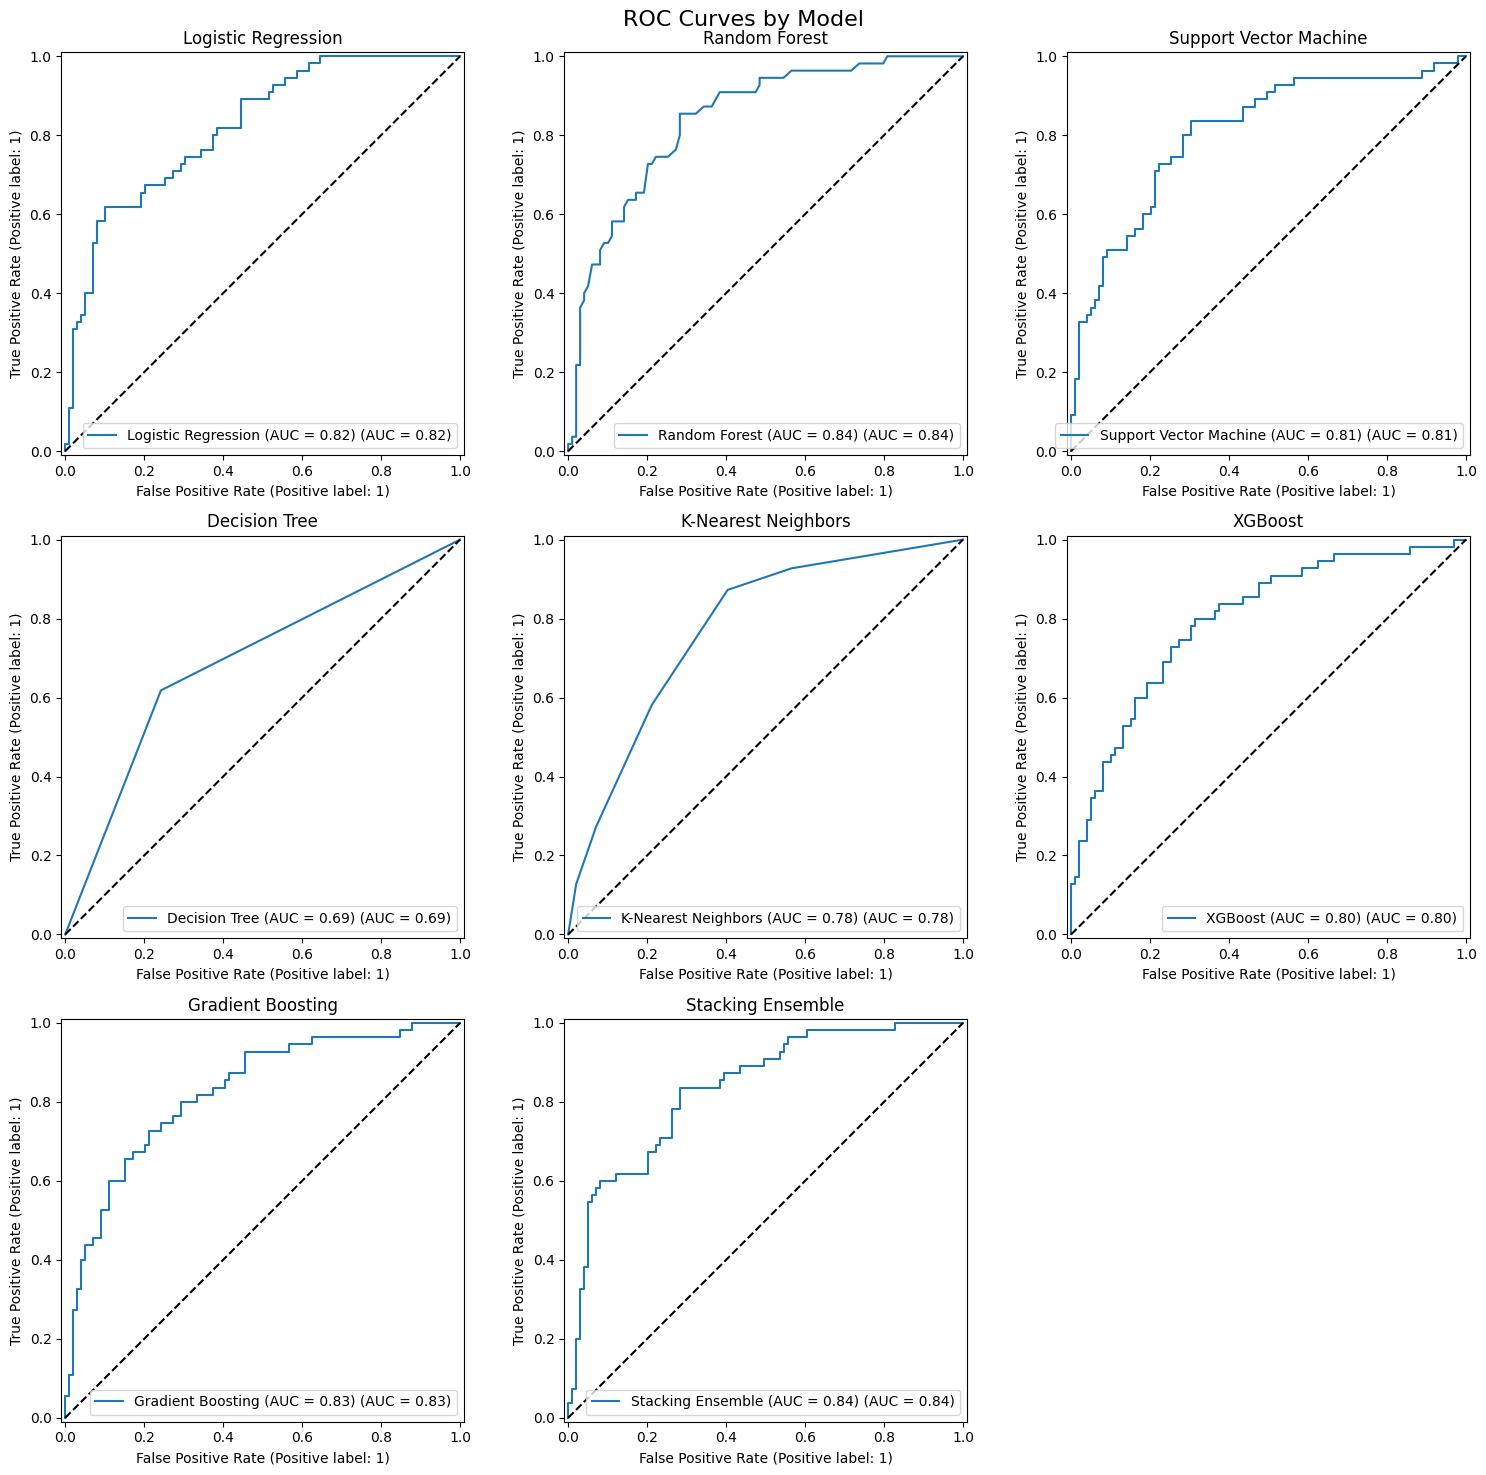

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Set up subplots
n_models = len(models)
n_cols = 3  # Adjust based on your preference
n_rows = (n_models + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
fig.suptitle('ROC Curves by Model', fontsize=16)
axes = axes.flatten()  # Flatten for easy iteration

# Plot ROC for each model
for i, (name, model) in enumerate(models.items()):
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(
            model, X_test, y_test,
            name=f'{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})',
            ax=axes[i]
        )
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_title(name)
        axes[i].legend(loc='lower right')

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('roc_subplots.png', dpi=300, bbox_inches='tight')  # Save for PPT
plt.show()

Saving the Model

In [51]:
model_save_path = '/content/models/best_model.pkl'
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
except Exception as e:
    print(" Error saving model:", e)
    traceback.print_exc()
    exit(1)

print("\n Model training complete.")
print(f" Best Model: {best_model_name} with accuracy: {best_score:.4f}")
print(f" Saved model at: {os.path.abspath(model_save_path)}")


 Model training complete.
 Best Model: Gradient Boosting with accuracy: 0.7288
 Saved model at: /content/models/best_model.pkl


Feature Importance of the best model

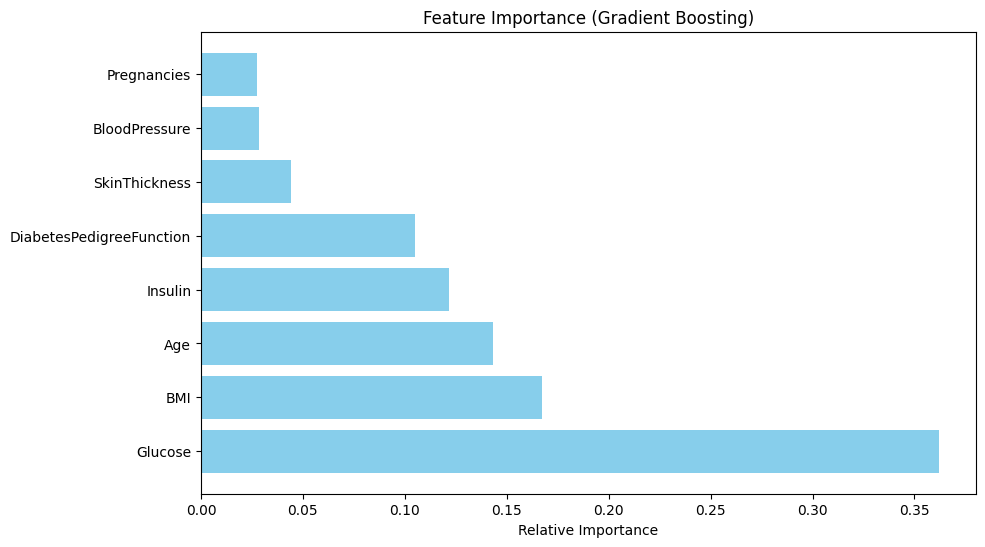

In [52]:
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    features = X.columns
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.barh(range(len(indices)), importances[indices], color='skyblue')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance (Gradient Boosting)')
    plt.savefig('feature_importance.png')  # Save for PPT
    plt.show()

Checking Existing Files

In [53]:
print("\nChecking saved files...")
print(f"Model file exists: {os.path.exists(model_save_path)}")


Checking saved files...
Model file exists: True


**Deploying**

In [54]:
# Path to the trained model
model_path = '/content/models/best_model.pkl'

# Load model
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Example input: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age]
sample = np.array([[1, 90, 62, 12, 66, 25.1, 0.167, 21]])

# Make prediction
prediction = model.predict(sample)

# Output result
print("Predicted Outcome:", "Diabetic" if prediction[0] == 1 else "Not Diabetic")
print("Working Directory:", os.getcwd())

Predicted Outcome: Diabetic
Working Directory: /content


**Diabetes Prediction App through Gradio**

In [55]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


Loading the Model

In [56]:
with open('/content/models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)

Model Testing for User Input

In [57]:
def predict_diabetes(pregnancies, glucose, bp, skinthickness, insulin, bmi, dpf, age):
    input_data = np.array([[pregnancies, glucose, bp, skinthickness, insulin, bmi, dpf, age]])
    prediction = model.predict(input_data)
    return "Diabetic" if prediction[0] == 1 else "Not Diabetic"


User Interface

In [58]:
import gradio as gr

iface = gr.Interface(
    fn=predict_diabetes,
    inputs=[
        gr.Number(label="Pregnancies"),
        gr.Number(label="Glucose"),
        gr.Number(label="Blood Pressure"),
        gr.Number(label="Skin Thickness"),
        gr.Number(label="Insulin"),
        gr.Number(label="BMI"),
        gr.Number(label="Diabetes Pedigree Function"),
        gr.Number(label="Age")
    ],
    outputs=gr.Text(label="Prediction"),
    title="Diabetes Prediction App",
    description="Enter the health metrics to predict if the person is diabetic."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f7251e74f35fe794cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
